In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import Optional, List, Tuple


In [13]:
def plot_cumulative_returns(melted_df: pd.DataFrame, 
                          selected_pods: Optional[List[str]] = None,
                          start_value: float = 100.0,
                          t_factor: int = 52,
                          figsize: Tuple[int, int] = (12, 8),
                          title: str = "Cumulative Returns",
                          show_stats: bool = True,
                          return_data: bool = False) -> Optional[pd.DataFrame]:
    """
    Plot cumulative returns for selected pods from melted timeseries data.
    
    Process:
    1. Filter for common period across selected pods
    2. Pivot to wide format
    3. Calculate returns using pct_change()
    4. Calculate cumulative returns starting from start_value
    5. Plot the results
    
    Parameters:
    -----------
    melted_df : pd.DataFrame
        Melted timeseries data with columns ['date', 'pod_id', 'price']
    selected_pods : List[str], optional
        List of pod_ids to plot. If None, plots all available pods.
    start_value : float, default=100.0
        Starting value for cumulative return calculation (base 100)
    t_factor : int, default=52
        Time factor for annualization (52 for weekly data, 252 for daily data, 12 for monthly data)
    figsize : Tuple[int, int], default=(12, 8)
        Figure size for the plot
    title : str, default="Cumulative Historical Returns"
        Title for the plot
    show_stats : bool, default=True
        Whether to display performance statistics
    return_data : bool, default=False
        Whether to return the cumulative returns DataFrame
        
    Returns:
    --------
    pd.DataFrame, optional
        Cumulative returns DataFrame if return_data=True
    """
    
    # Validate input data
    required_cols = ['date', 'pod_id', 'price']
    if not all(col in melted_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # Make a copy to avoid modifying original data
    df = melted_df.copy()
    
    # Ensure date column is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter for selected pods
    if selected_pods is not None:
        available_pods = df['pod_id'].unique()
        missing_pods = set(selected_pods) - set(available_pods)
        if missing_pods:
            warnings.warn(f"The following pods are not in the data: {missing_pods}")
        
        valid_pods = [pod for pod in selected_pods if pod in available_pods]
        if not valid_pods:
            raise ValueError("None of the selected pods are available in the data")
        
        df = df[df['pod_id'].isin(valid_pods)]
        print(f"Selected {len(valid_pods)} pods: {valid_pods}")
    else:
        print(f"Using all {df['pod_id'].nunique()} available pods")
    
    # Find common period (dates where all selected pods have data)
    pod_date_coverage = df.groupby('pod_id')['date'].agg(['min', 'max'])
    common_start = pod_date_coverage['min'].max()  # Latest start date
    common_end = pod_date_coverage['max'].min()    # Earliest end date
    
    print(f"Common period: {common_start.date()} to {common_end.date()}")
    
    # Filter data to common period to count actual observations
    df_common = df[(df['date'] >= common_start) & (df['date'] <= common_end)]
    
    # Count actual periods in the common timeframe
    if not df_common.empty:
        # Count unique dates in the common period
        actual_periods = df_common['date'].nunique()
        
        # Calculate years for context
        total_days = (common_end - common_start).days + 1
        years = total_days / 365.25
        
        print(f"Total periods in common timeframe: {actual_periods}")
        print(f"Approximate years: {years:.2f}")
        print(f"Average periods per year: {actual_periods/years:.1f} (t_factor={t_factor})")
    else:
        print("No common period found!")
        actual_periods = 0
    
    # Check if we have sufficient data
    if df_common.empty or actual_periods == 0:
        raise ValueError("No common period found for the selected pods")
    
    # Pivot to wide format for easier return calculation
    price_matrix = df_common.pivot(index='date', columns='pod_id', values='price')
    
    # Sort by date to ensure proper time series order
    price_matrix = price_matrix.sort_index()
    
    # Check for missing values in the common period
    missing_data = price_matrix.isnull().sum()
    if missing_data.any():
        print("Warning: Missing values found in common period:")
        print(missing_data[missing_data > 0])
        print("Forward filling missing values...")
        price_matrix = price_matrix.fillna(method='ffill')
    
    # Calculate returns using pct_change
    returns = price_matrix.pct_change()
    
    # Calculate cumulative returns starting from start_value
    cumulative_returns = (1 + returns).cumprod() * start_value
    
    # Set the first value to start_value for all series
    cumulative_returns.iloc[0] = start_value
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot each pod with different colors
    for pod in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[pod], 
                label=pod, linewidth=2, alpha=0.8)
    
    # Customize the plot
    plt.title(f"{title}\n({common_start.date()} to {common_end.date()})", 
              fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'Cumulative Value (Base {start_value})', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add horizontal line at start_value
    plt.axhline(y=start_value, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Format x-axis
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Display performance statistics
    if show_stats:
        print("\n" + "="*60)
        print("PERFORMANCE STATISTICS")
        
        # Determine frequency description based on t_factor
        if t_factor == 52:
            freq_desc = "weekly"
        elif t_factor == 252:
            freq_desc = "daily"
        elif t_factor == 12:
            freq_desc = "monthly"
        elif t_factor == 26:
            freq_desc = "bi-weekly"
        elif t_factor == 4:
            freq_desc = "quarterly"
        else:
            freq_desc = f"{t_factor} periods/year"
            
        print(f"Data Frequency: {freq_desc} ({t_factor} periods per year)")
        print(f"Actual observations: {actual_periods} periods")
        print("="*60)
        
        final_values = cumulative_returns.iloc[-1]
        total_returns = (final_values / start_value - 1) * 100
        
        # Calculate annualized metrics using actual number of periods
        n_periods = len(cumulative_returns)
        n_years = n_periods / t_factor  # Using t_factor for proper annualization
        
        annualized_returns = (final_values / start_value) ** (1/n_years) - 1
        
        # Calculate volatility (annualized using t_factor)
        annualized_vol = returns.std() * np.sqrt(t_factor)
        
        # Calculate Sharpe ratio (assumes 0% risk-free rate)
        sharpe_ratio = annualized_returns / annualized_vol
        
        # Calculate maximum drawdown
        running_max = cumulative_returns.cummax()
        drawdowns = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdowns.min()
        
        # Create summary DataFrame
        stats_df = pd.DataFrame({
            'Final Value': final_values,
            'Total Return (%)': total_returns,
            'Annualized Return (%)': annualized_returns * 100,
            'Annualized Vol (%)': annualized_vol * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100
        })
        
        print(stats_df.round(2))
        
        # best and worst performers
        best_performer = total_returns.idxmax()
        worst_performer = total_returns.idxmin()
        
        print(f"\nAnalysis Period: {n_years:.2f} years ({n_periods} {freq_desc} observations)")
        print(f"Best Performer: {best_performer} ({total_returns[best_performer]:.2f}%)")
        print(f"Worst Performer: {worst_performer} ({total_returns[worst_performer]:.2f}%)")
    
    plt.show()
    
    if return_data:
        return cumulative_returns

In [14]:
pods_px = pd.read_csv('pod_nav_history.csv')

Using all 22 available pods
Common period: 2016-04-08 to 2025-07-04
Total periods in common timeframe: 483
Approximate years: 9.24
Average periods per year: 52.3 (t_factor=52)

PERFORMANCE STATISTICS
Data Frequency: weekly (52 periods per year)
Actual observations: 483 periods
             Final Value  Total Return (%)  Annualized Return (%)  \
pod_id                                                              
0431214C JP       322.63            222.63                  13.44   
ASLAX US          133.36             33.36                   3.15   
AUDHYBI LX        214.61            114.61                   8.57   
BDMAX US          130.92             30.92                   2.94   
BGTFDLX LX        149.40             49.40                   4.42   
CPLSX US          178.39             78.39                   6.43   
DIAMX US          123.49             23.49                   2.30   
EXCRISA LX        127.92             27.92                   2.69   
FFAAYAU LX        234.04        

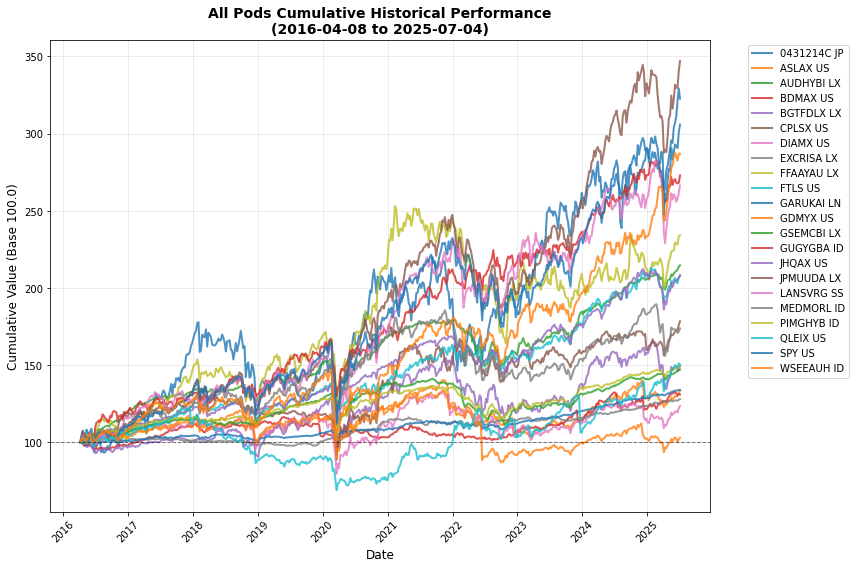

In [21]:
plot_cumulative_returns(pods_px, title="All Pods Cumulative Historical Performance")

Selected 3 pods: ['JPMUUDA LX', 'GDMYX US', 'FTLS US']
Common period: 2014-09-12 to 2025-07-04
Total periods in common timeframe: 565
Approximate years: 10.81
Average periods per year: 52.3 (t_factor=52)

PERFORMANCE STATISTICS
Data Frequency: weekly (52 periods per year)
Actual observations: 565 periods
            Final Value  Total Return (%)  Annualized Return (%)  \
pod_id                                                             
FTLS US          223.76            123.76                   7.69   
GDMYX US          98.43             -1.57                  -0.15   
JPMUUDA LX       343.32            243.32                  12.02   

            Annualized Vol (%)  Sharpe Ratio  Max Drawdown (%)  
pod_id                                                          
FTLS US                  10.56          0.73            -19.07  
GDMYX US                 12.63         -0.01            -35.02  
JPMUUDA LX               16.48          0.73            -29.12  

Analysis Period: 10.87 year

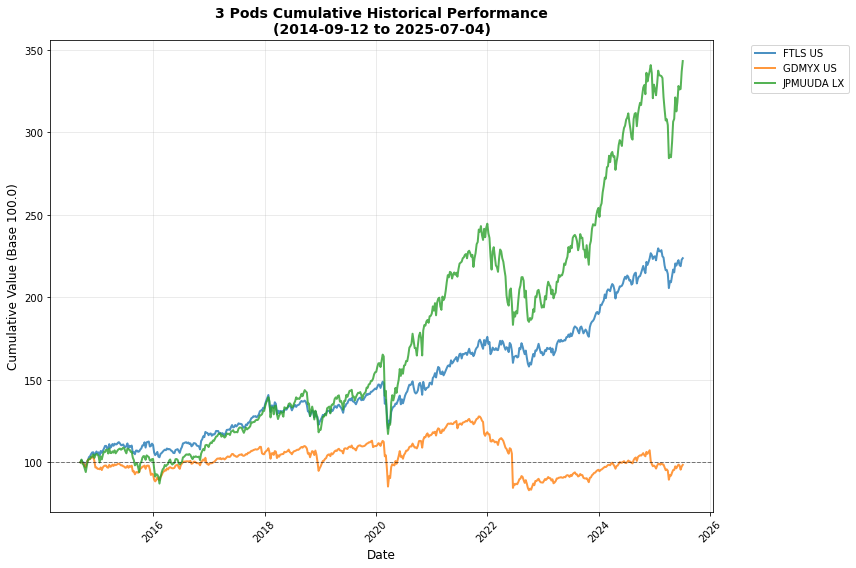

In [22]:
plot_cumulative_returns(pods_px, 
                        selected_pods = ['JPMUUDA LX', 'GDMYX US', 'FTLS US'],
                        title="3 Pods Cumulative Historical Performance")